<a href="https://colab.research.google.com/github/carlosruedap/capstone/blob/main/Mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Get the path to the images directory on Google Drive
image_dir = '/content/drive/MyDrive/SIC/Capstone/Imagenes sin fondo/Imagenes segmentadas'

# List all the files in the images directory
!ls "{image_dir}"

# Upload the images to the current working directory
!cp "{image_dir}"/* .


Mounted at /content/drive
Image10_seg_0_0.jpg  Image32_seg_0_0.jpg  Image54_seg_0_0.jpg  Image76_seg_0_0.jpg
Image10_seg_0_1.jpg  Image32_seg_0_1.jpg  Image54_seg_0_1.jpg  Image76_seg_0_1.jpg
Image10_seg_0_2.jpg  Image32_seg_0_2.jpg  Image54_seg_0_2.jpg  Image76_seg_0_2.jpg
Image10_seg_1_0.jpg  Image32_seg_1_0.jpg  Image54_seg_1_0.jpg  Image76_seg_1_0.jpg
Image10_seg_1_1.jpg  Image32_seg_1_1.jpg  Image54_seg_1_1.jpg  Image76_seg_1_1.jpg
Image10_seg_1_2.jpg  Image32_seg_1_2.jpg  Image54_seg_1_2.jpg  Image76_seg_1_2.jpg
Image11_seg_0_0.jpg  Image33_seg_0_0.jpg  Image55_seg_0_0.jpg  Image77_seg_0_0.jpg
Image11_seg_0_1.jpg  Image33_seg_0_1.jpg  Image55_seg_0_1.jpg  Image77_seg_0_1.jpg
Image11_seg_0_2.jpg  Image33_seg_0_2.jpg  Image55_seg_0_2.jpg  Image77_seg_0_2.jpg
Image11_seg_1_0.jpg  Image33_seg_1_0.jpg  Image55_seg_1_0.jpg  Image77_seg_1_0.jpg
Image11_seg_1_1.jpg  Image33_seg_1_1.jpg  Image55_seg_1_1.jpg  Image77_seg_1_1.jpg
Image11_seg_1_2.jpg  Image33_seg_1_2.jpg  Image55_seg_1_2.jpg

#Imagen inicial: 1
Número total de imágenes a procesar: 1
Umbral de circularidad (0.0 - 1.0): 0.1


Procesando imágenes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing image: Image76_seg_1_2.jpg


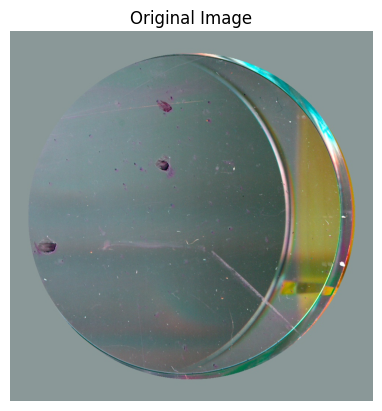

Is the image empty? (1 for yes / 0 for no): 0
Do you want to use the elbow method to determine the number of clusters? (1 for yes / 0 for no): 0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


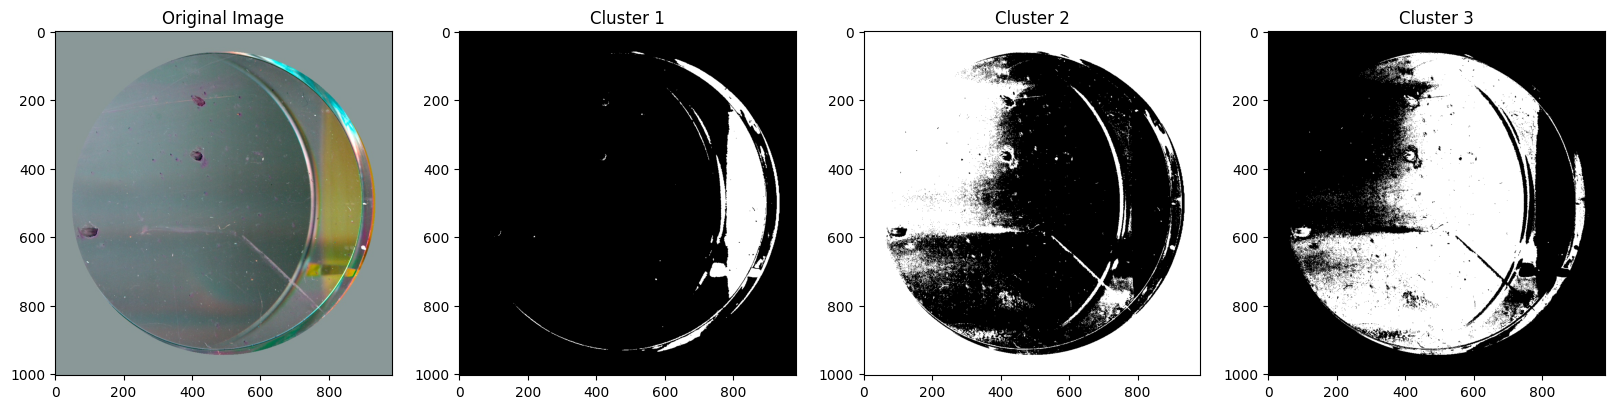

Enter the cluster number to label the image (1 to 3): 3


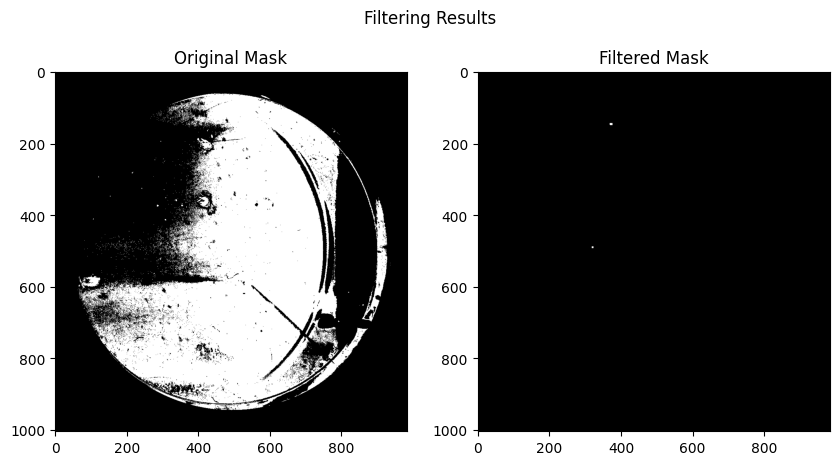

Is the filtered mask optimal? (1 for yes / 0 for no): 0
Umbral de circularidad (0.0 - 1.0): 0.4
Processing image: Image76_seg_1_2.jpg


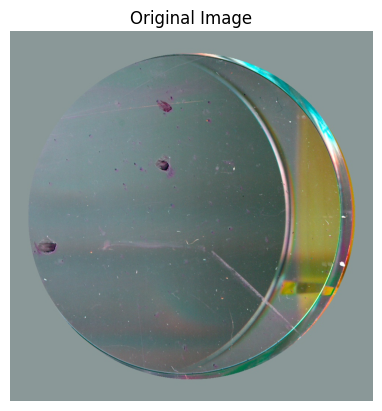

Is the image empty? (1 for yes / 0 for no): 0
Do you want to use the elbow method to determine the number of clusters? (1 for yes / 0 for no): 1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


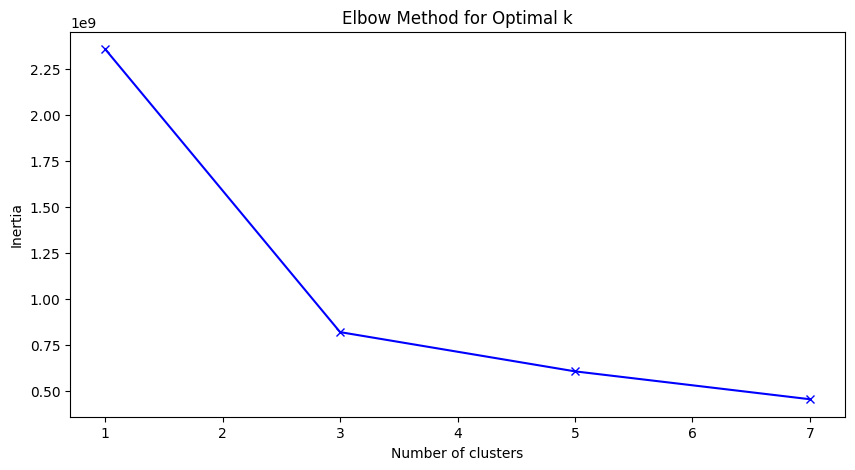

Enter the optimal number of clusters (based on the elbow curve): 5


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


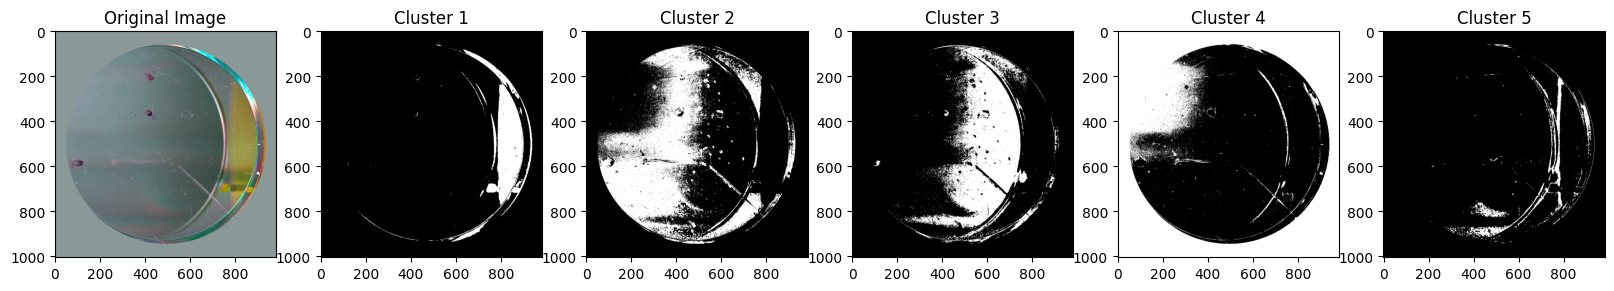

Enter the cluster number to label the image (1 to 5): 1


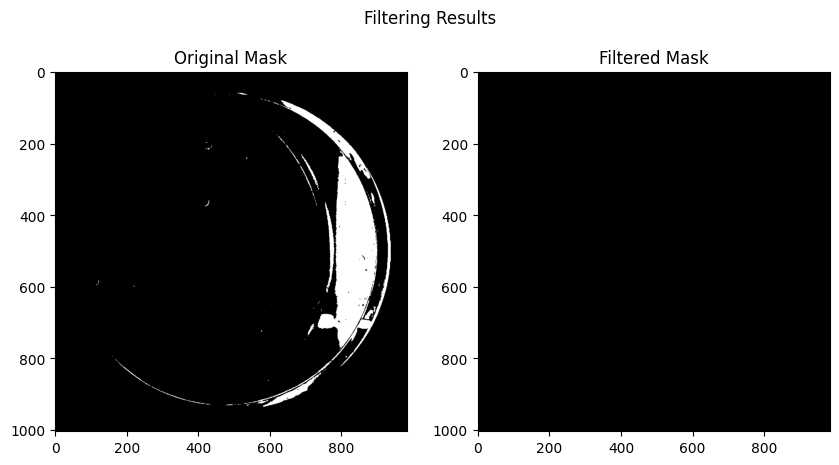

Is the filtered mask optimal? (1 for yes / 0 for no): 0
Umbral de circularidad (0.0 - 1.0): 0.4
Processing image: Image76_seg_1_2.jpg


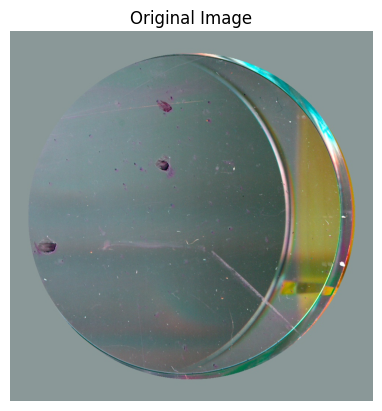

Is the image empty? (1 for yes / 0 for no): 0
Do you want to use the elbow method to determine the number of clusters? (1 for yes / 0 for no): 1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


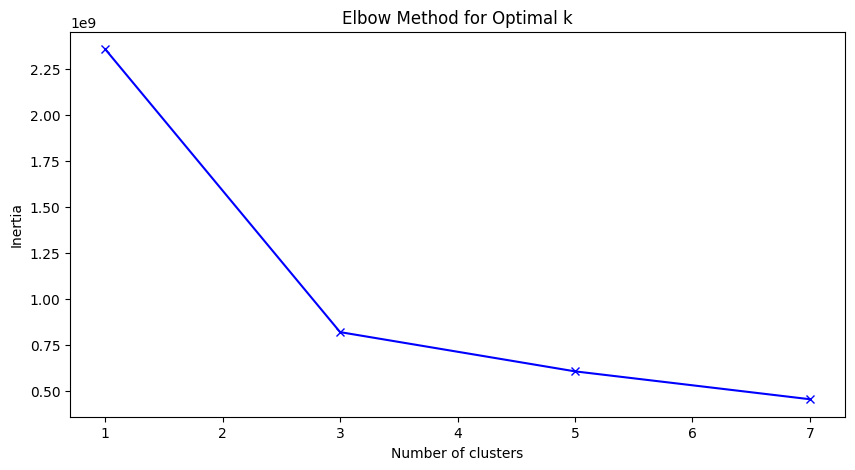

Enter the optimal number of clusters (based on the elbow curve): 7


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


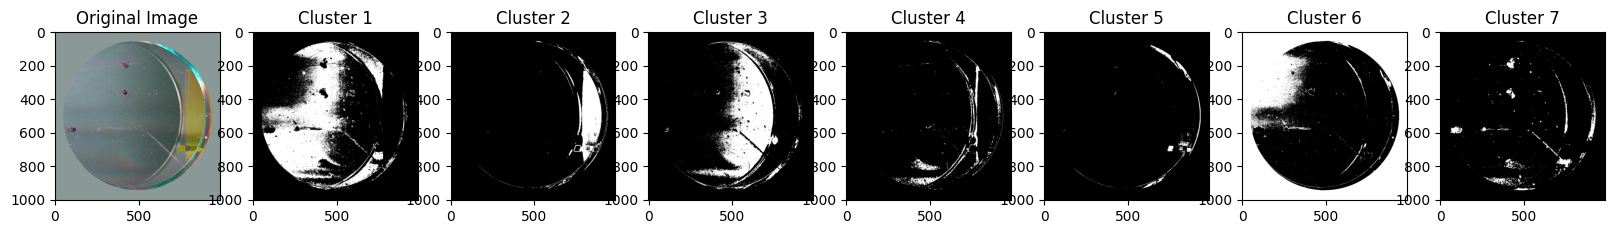

Enter the cluster number to label the image (1 to 7): 7


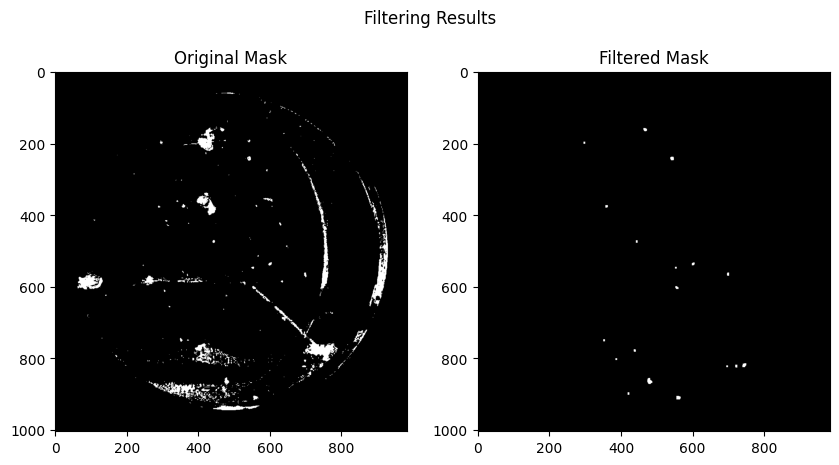

Is the filtered mask optimal? (1 for yes / 0 for no): 0
Umbral de circularidad (0.0 - 1.0): 0.1
Processing image: Image76_seg_1_2.jpg


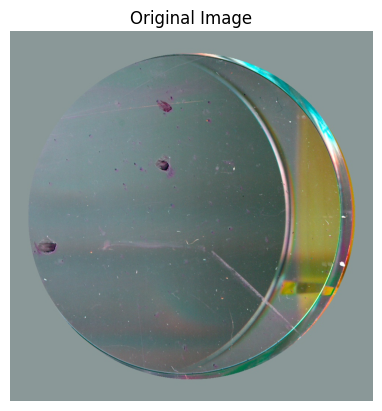

Is the image empty? (1 for yes / 0 for no): 1


Procesando imágenes: 100%|██████████| 1/1 [04:39<00:00, 279.58s/it]

Labeled image saved as /content/drive/MyDrive/SIC/Capstone/labels/Image76_seg_1_2_label.png
Mask saved as /content/drive/MyDrive/SIC/Capstone/masks/Image76_seg_1_2_mask.png
Procesamiento de imágenes completado.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
import time
from tqdm import tqdm


# Create a folder if it does not exist
def create_folder_if_not_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

# Display original and filtered masks side-by-side
def display_masks(original, filtered, title):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original Mask')
    axes[1].imshow(cv2.cvtColor(filtered, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Filtered Mask')
    fig.suptitle(title)
    plt.show()

# Filter contours in a binary mask based on circularity
def filter_contours_by_circularity(mask, circularity_threshold):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = [cnt for cnt in contours if cv2.arcLength(cnt, True) != 0 and 4 * np.pi * cv2.contourArea(cnt) / (cv2.arcLength(cnt, True) ** 2) > circularity_threshold]

    filtered_mask = np.zeros_like(mask)
    cv2.drawContours(filtered_mask, filtered_contours, -1, 255, -1)  # Fill the contours

    # Apply morphology to clean up and connect contours
    kernel = np.ones((5, 5), np.uint8)
    filtered_mask = cv2.morphologyEx(filtered_mask, cv2.MORPH_CLOSE, kernel)
    filtered_mask = cv2.morphologyEx(filtered_mask, cv2.MORPH_OPEN, kernel)

    return filtered_mask

# Find the optimal number of clusters using the elbow method
def find_optimal_clusters(data, max_clusters):
    iters = range(1, max_clusters + 1, 2)  # Larger step for efficiency
    inertia = [KMeans(n_clusters=k, random_state=0).fit(data).inertia_ for k in iters]
    return iters, inertia

# Process each image
def process_image(name, labels_folder, masks_folder, circularity_threshold):
    while True:
        print(f"Processing image: {name}")

        # Load the image
        image = cv2.imread(name)
        if image is None:
            print(f"Error loading image: {name}")
            return

        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Display the loaded image
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        plt.show()

        time.sleep(0.3)

        # Check if the image is empty
        while True:
            try:
                is_empty = int(input('Is the image empty? (1 for yes / 0 for no): '))
                if is_empty in [0, 1]:
                    break
                else:
                    print("Please enter 0 or 1.")
            except ValueError:
                print("Invalid input. Please enter an integer.")

        base_filename = os.path.splitext(os.path.basename(name))[0]

        if is_empty == 1:
            filtered_mask = np.zeros(image.shape[:2], dtype=np.uint8)

            label_image_path = os.path.join(labels_folder, f'{base_filename}_label.png')
            cv2.imwrite(label_image_path, filtered_mask)

            mask_image_path = os.path.join(masks_folder, f'{base_filename}_mask.png')
            cv2.imwrite(mask_image_path, filtered_mask)

            print(f"Labeled image saved as {label_image_path}")
            print(f"Mask saved as {mask_image_path}")

        else:
            while True:
                try:
                    use_elbow_method = int(input('Do you want to use the elbow method to determine the number of clusters? (1 for yes / 0 for no): '))
                    if use_elbow_method in [0, 1]:
                        break
                    else:
                        print("Please enter 0 or 1.")
                except ValueError:
                    print("Invalid input. Please enter an integer.")

            if use_elbow_method == 1:
                pixels = hsv_image.reshape((-1, 3))
                max_clusters = 7
                iters, inertia = find_optimal_clusters(pixels, max_clusters)

                plt.figure(figsize=(10, 5))
                plt.plot(iters, inertia, 'bx-')
                plt.xlabel('Number of clusters')
                plt.ylabel('Inertia')
                plt.title('Elbow Method for Optimal k')
                plt.show()

                optimal_clusters = int(input('Enter the optimal number of clusters (based on the elbow curve): '))
            else:
                optimal_clusters = 3

            pixels = hsv_image.reshape((-1, 3))
            kmeans = KMeans(n_clusters=optimal_clusters, random_state=0).fit(pixels)
            labels = kmeans.labels_
            segmented_image = labels.reshape(hsv_image.shape[:2])

            fig, axs = plt.subplots(1, optimal_clusters + 1, figsize=(20, 5))
            axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            axs[0].set_title('Original Image')

            for i in range(optimal_clusters):
                mask = (segmented_image == i).astype(np.uint8) * 255
                axs[i + 1].imshow(mask, cmap='gray')
                axs[i + 1].set_title(f'Cluster {i + 1}')

            plt.show()

            cluster_to_label = int(input(f'Enter the cluster number to label the image (1 to {optimal_clusters}): ')) - 1
            mask = (segmented_image == cluster_to_label).astype(np.uint8) * 255
            filtered_mask = filter_contours_by_circularity(mask, circularity_threshold)
            display_masks(mask, filtered_mask, "Filtering Results")

            # Ask if the filtered mask is optimal
            while True:
                try:
                    is_optimal = int(input('Is the filtered mask optimal? (1 for yes / 0 for no): '))
                    if is_optimal in [0, 1]:
                        break
                    else:
                        print("Please enter 0 or 1.")
                except ValueError:
                    print("Invalid input. Please enter an integer.")

            if is_optimal == 1:

                label_image_path = os.path.join(labels_folder, f'{base_filename}_label.png')
                cv2.imwrite(label_image_path, filtered_mask)

                mask_image_path = os.path.join(masks_folder, f'{base_filename}_mask.png')
                cv2.imwrite(mask_image_path, filtered_mask)

                print(f"Labeled image saved as {label_image_path}")
                print(f"Mask saved as {mask_image_path}")

                break

            else:
                try:
                    circularity_threshold = float(input('Umbral de circularidad (0.0 - 1.0): '))
                    if 0.0 <= circularity_threshold <= 1.0:
                      continue
                    else:
                        print("El umbral debe estar entre 0.0 y 1.0.")
                except ValueError:
                    print("Entrada inválida. Por favor ingrese un número decimal.")
                continue  # Restart the process from selecting the clustering method


        break  # Exit the loop if the image processing is completed



def generate_image_names(start_image_number, total_images):

    base_name = "Image"
    rows = 2
    cols = 3

    image_names = []
    for i in range (total_images):
      for row in range(rows):
          for col in range(cols):
              image_name = f"{base_name}{start_image_number+i}_seg_{row}_{col}.jpg"
              image_names.append(image_name)
    print(image_names)
    return image_names


def main():
    labels_folder = '/content/drive/MyDrive/SIC/Capstone/labels'
    masks_folder = '/content/drive/MyDrive/SIC/Capstone/masks'

    create_folder_if_not_exists(labels_folder)
    create_folder_if_not_exists(masks_folder)

    start_image_number = int(input('#Imagen inicial: '))
    total_images = int(input('Número total de imágenes a procesar: '))
    try:
        circularity_threshold = float(input('Umbral de circularidad (0.0 - 1.0): '))
        if 0.0 <= circularity_threshold <= 1.0:
            pass
        else:
            print("El umbral debe estar entre 0.0 y 1.0.")
    except ValueError:
        print("Entrada inválida. Por favor ingrese un número decimal.")

    #image_names = generate_image_names(start_image_number, total_images)
    image_names = ['Image76_seg_1_2.jpg']
    for i, name in enumerate(tqdm(image_names, desc="Procesando imágenes")):
        process_image(name, labels_folder, masks_folder, circularity_threshold)

        if (i + 1) % 6 == 0 and (i + 1) < total_images:
            while True:
                try:
                    circularity_threshold = float(input('Umbral de circularidad (0.0 - 1.0): '))
                    if 0.0 <= circularity_threshold <= 1.0:
                        break
                    else:
                        print("El umbral debe estar entre 0.0 y 1.0.")
                except ValueError:
                    print("Entrada inválida. Por favor ingrese un número decimal.")

    print("Procesamiento de imágenes completado.")


if __name__ == "__main__":
    main()